In [55]:
import pandas as pd

In [56]:
import numpy as np

In [57]:
import scipy as sc
import pymc3 as pm
import seaborn as sns

In [58]:
import arviz as az

In [59]:
import statsmodels.formula.api as smf 
import statsmodels.api as sm

In [60]:
import warnings
warnings.filterwarnings(action='ignore')

In [61]:
sns.set_palette("Dark2")
sns.set_style("darkgrid")

In [62]:
az.style.use('arviz-darkgrid')

# Selection Distort

In [26]:
N = 1000
trustworthy = sc.stats.norm.rvs(loc=10,scale=1,size=N)
newsworthy = sc.stats.norm.rvs(loc=10,scale=1,size=N)
total_score =  trustworthy + newsworthy
publish_df = pd.DataFrame({'tw':trustworthy,'nw':newsworthy,'ts':total_score})

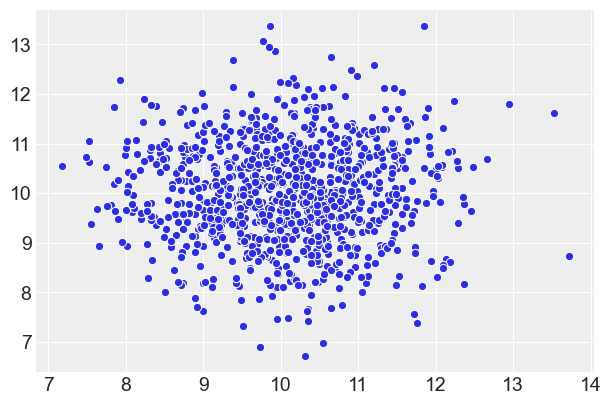

In [27]:
sns.scatterplot(trustworthy,newsworthy);

In [30]:
publish_df

,tw,nw,ts
tw,1.000000,0.018693,0.708528
nw,0.018693,1.000000,0.718804
ts,0.708528,0.718804,1.000000


In [34]:
publish_df[total_score>np.quantile(total_score,0.9)].corr()

,tw,nw,ts
tw,1.000000,-0.695061,0.391938
nw,-0.695061,1.000000,0.389008
ts,0.391938,0.389008,1.000000


### Multicollinearity

In [35]:
N = 100

In [39]:
height = sc.stats.norm.rvs(loc=160,scale=20,size=N)
prop = sc.stats.uniform.rvs(loc=0.4,scale=0.1,size=N)
leg_left = height*prop + sc.stats.norm.rvs(loc=0,scale=1,size=N)
leg_right = height*prop + sc.stats.norm.rvs(loc=0,scale=1,size=N)

In [40]:
height_data = pd.DataFrame({'h':height,'lf':leg_left,'lr':leg_right})

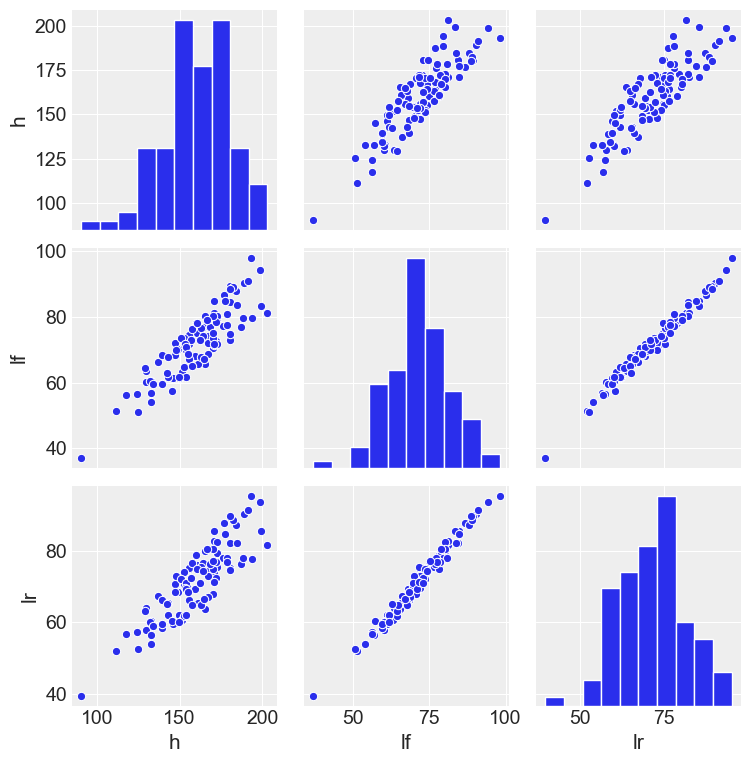

In [41]:
sns.pairplot(height_data);

In [46]:
varname = '~mu'

In [57]:
with pm.Model() as model_height:
    alpha = pm.Normal('alpha',mu=150,sigma=20)
    beta = pm.Normal('beta',mu=2,sigma=10,shape=2)
    sigma = pm.HalfNormal('sigma',sigma=1)
    mu = pm.Deterministic('mu',alpha + beta[0]*height_data.lf + beta[1]*height_data.lr)
    h = pm.Normal('height',mu=mu,sigma=sigma,observed=height_data.h)
    trace_heigh = pm.sample(1000,tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:50<00:00, 157.57draws/s]
The acceptance probability does not match the target. It is 0.8872461514469252, but should be close to 0.8. Try to increase the number of tuning steps.


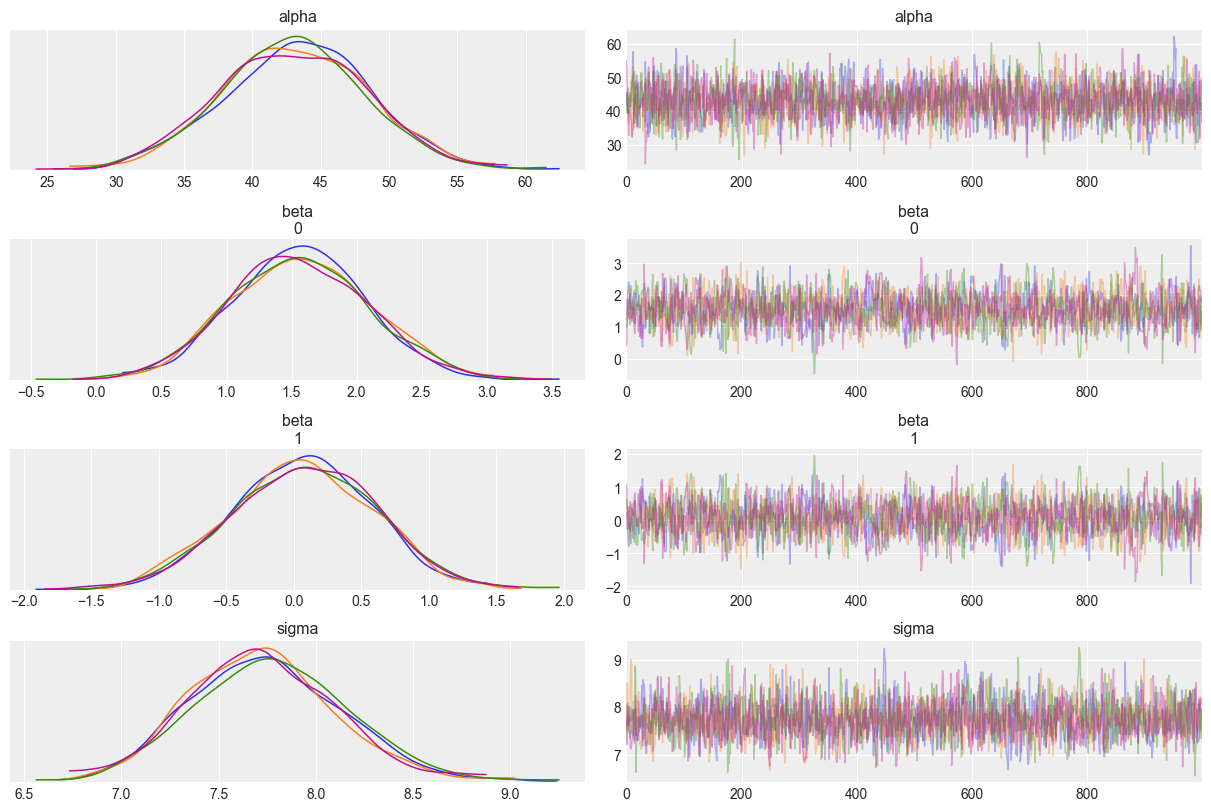

In [58]:
az.plot_trace(trace_heigh,var_names=varname);

In [59]:
az.summary(trace_heigh,var_names=varname)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,43.086,5.364,32.714,52.712,0.108,0.077,2474.0,2448.0,2474.0,2310.0,1.0
beta[0],1.561,0.523,0.592,2.538,0.014,0.010,1460.0,1428.0,1457.0,1628.0,1.0
beta[1],0.069,0.524,-0.954,0.986,0.014,0.010,1427.0,1379.0,1427.0,1554.0,1.0
sigma,7.743,0.389,7.018,8.465,0.008,0.006,2281.0,2270.0,2291.0,2096.0,1.0


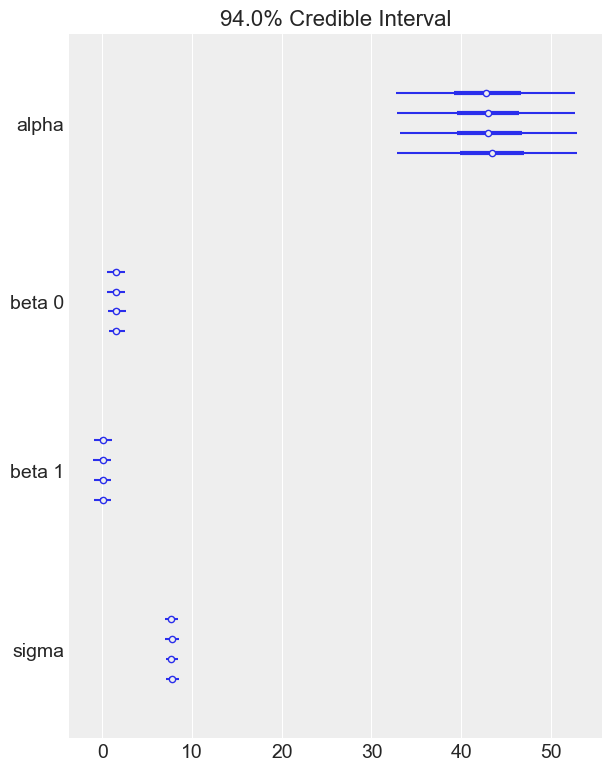

In [61]:
az.plot_forest(trace_heigh,var_names=varname);

**we see that leg right has been given really less weight, although the prediction will be perfect but the intepretation will be bad**

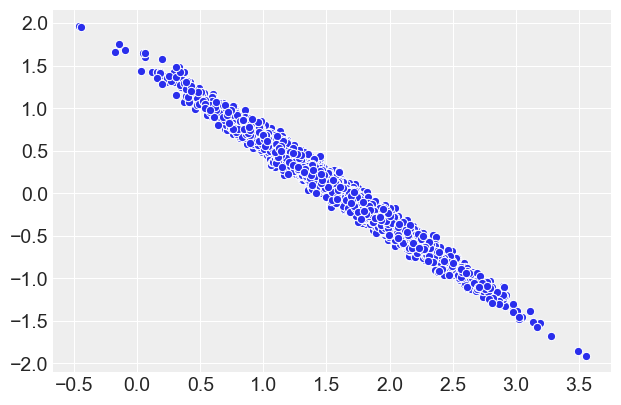

In [70]:
sns.scatterplot(trace_heigh['beta'][:,0],trace_heigh['beta'][:,1]);

 
> **When two predictor variables are very strongly correlated, including both in a model may lead to confusion. The posterior distribution isn’t wrong, in such cases. It’s telling you that the question you asked cannot be answered with these data.**

> **Hence as you can see from above graph, there is long range of plaussible values of multi-collinear variable that satisfies the equation, hence the posterior distribution of the predictors spreads out, removing out the intuition.**


 
>**Some fields actually teach students to inspect pairwise correlations before fitting a model, to identify and drop highly correlated predictors. This is a mistake. Pairwise correlations are not the problem. It is the conditional associations—not correlations—that matter. And even then, the right thing to do will de- pend upon what is causing the collinearity. The associations within the data alone are not enough to decide what to do.**


### Post Treatment Bias

In [137]:

# number of plants
N = 1000

# simulate initial heights
h0 = sc.stats.norm.rvs(size = N, loc = 10, scale = 2)

# assign treatments and simulate fungus and growth
treatment = np.repeat([0, 1], [N/2]*2)
fungus = np.random.binomial(n=1, p=(0.5-treatment * 0.4), size=N)
h1 = h0 + sc.stats.norm.rvs(size= N, loc= 5- 3*fungus, scale=1)

# compose a clean data frame
d = pd.DataFrame({'h0': h0,
                  'h1': h1,
                  'Treatment':treatment,
                  'Fungus': fungus})

In [138]:
var_names='~mu'

In [139]:
with pm.Model() as model_treatment:
    a = pm.Normal('a',mu = 0, sd=100)
    bh = pm.Normal('bh',mu = 0, sd=10)
    bt = pm.Normal('bt',mu = 0, sd=10)
    bf = pm.Normal('bf',mu = 0, sd=10)
    mu = pm.Deterministic('mu',a + bh * h0 + bt * treatment + bf * fungus)
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    h1 = pm.Normal('h1', mu = mu, sd=sigma, observed = d['h1'])
    trace_treatment = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bf, bt, bh, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:12<00:00, 643.47draws/s]


In [140]:
az.summary(trace_treatment, var_names, credible_interval=.89).round(3)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,5.252,0.176,4.969,5.526,0.004,0.003,2162.0,2162.0,2161.0,2141.0,1.0
bh,0.970,0.016,0.944,0.995,0.000,0.000,2323.0,2320.0,2324.0,2405.0,1.0
bt,0.039,0.070,-0.073,0.152,0.001,0.001,2990.0,2066.0,2987.0,2623.0,1.0
bf,-2.932,0.075,-3.050,-2.811,0.001,0.001,2829.0,2821.0,2838.0,2787.0,1.0
sigma,0.997,0.022,0.958,1.029,0.000,0.000,2830.0,2819.0,2846.0,2342.0,1.0


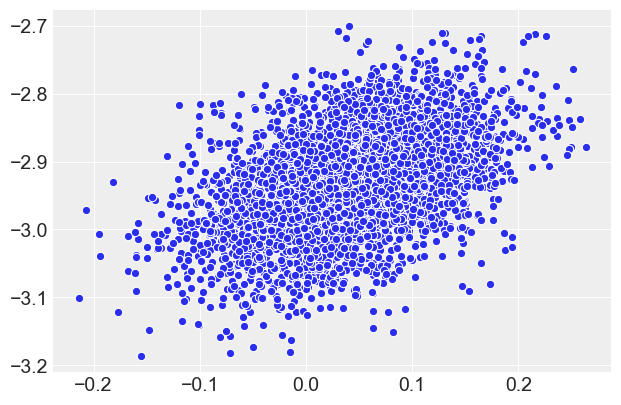

In [141]:
sns.scatterplot(trace_treatment['bt'],trace_treatment['bf']);

>**This tell that treatment has neglible effect on plants final height.
Presence of fungus does have an effect**


In [83]:
with pm.Model() as m5_14:
    a = pm.Normal('a',mu = 0, sd=100)
    bh = pm.Normal('bh',mu = 0, sd=10)
    bt = pm.Normal('bt',mu = 0, sd=10)
    mu = pm.Deterministic('mu',a + bh * h0 + bt * treatment)
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    h1 = pm.Normal('h1', mu = mu, sd=sigma, observed =d['h1'])
    trace_5_14 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bt, bh, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:08<00:00, 961.08draws/s] 


In [85]:
az.summary(trace_5_14, var_names, credible_interval=.89).round(3)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,3.569,0.804,2.279,4.855,0.021,0.015,1488.0,1485.0,1498.0,1773.0,1.0
bh,1.024,0.078,0.898,1.148,0.002,0.001,1548.0,1546.0,1555.0,1845.0,1.0
bt,0.967,0.325,0.429,1.470,0.007,0.005,2395.0,2334.0,2416.0,1984.0,1.0
sigma,1.585,0.117,1.398,1.760,0.002,0.002,2602.0,2558.0,2665.0,2193.0,1.0


>**Although when we do not consider fungus variable it shows strong effects**

> **What is happening is that fungus is post treatment variable, but including post-treatment variables can actually mask the treatment itself, i.e once we have post-treatment variable, having treatment variable does not really gives us any info.**

*****

#  Prediction and causal inference are just not the same task. No statistical procedure can substitute for scientific knowledge and attention to it. We need multiple models because they help us understand causal paths, not just so we can choose one or another for prediction.

*****

```Here is another example thats simulates that treatment did not have any effect on height, but some other variable (moisture) effected both fungus and height. Now including both fungus and treatment gave importance to treatment again leading to confounding :
```

In [120]:
N = 1000
h0 = sc.stats.norm.rvs(loc=10,scale=1,size=1000)
treatment = np.repeat([0,1],N/2)
moisture = sc.stats.bernoulli.rvs(p=0.5,loc=0,size=N)
fungus = sc.stats.binom.rvs(N,p=0.5- 0.4*treatment + 0.4*moisture)
h1 = h0 + 1.2*moisture + sc.stats.norm.rvs(0,1,N)
treatment_data = pd.DataFrame({'h0':h0,'moisture':moisture,'fungus':fungus,'h1':h1,'treatment':treatment})

In [122]:
with pm.Model() as model_fungus:
    a = pm.Normal('a',mu = 10, sd=1)
    bh = pm.Uniform('bh',lower = 1, upper=1.5)
    bt = pm.Normal('bt',mu = 0, sd=10)
    bf = pm.Normal('bf',mu = 0, sd=10)
    mu = pm.Deterministic('mu',a + bh * treatment_data.h0 + bt * treatment_data.treatment + bf * treatment_data.fungus)
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    h1 = pm.Normal('h1', mu = mu, sd=sigma, observed = treatment_data['h1'])
    trace_fungus = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bf, bt, bh, a]
Sampling 4 chains, 11 divergences: 100%|██████████| 8000/8000 [00:16<00:00, 481.35draws/s]
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [124]:
az.summary(trace_fungus,var_names=var_names)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-1.288,0.139,-1.547,-1.030,0.006,0.005,494.0,428.0,525.0,268.0,1.01
bt,0.989,0.091,0.816,1.152,0.002,0.002,1649.0,1649.0,1646.0,1907.0,1.00
bf,0.003,0.000,0.002,0.003,0.000,0.000,1362.0,1324.0,1363.0,2375.0,1.00
bh,1.007,0.006,1.000,1.018,0.000,0.000,328.0,325.0,645.0,231.0,1.01
sigma,1.025,0.023,0.981,1.065,0.000,0.000,2146.0,2142.0,2154.0,2551.0,1.00


>**this shows that treatment variable has effect, although in reality it does not**

## Collider bias

>And it means we have to pay attention to pro- cesses that select our sample of observations and may distort associations among variables. But the same phenomenon will also generate a misleading association inside a statistical model, when you include the collider as a predictor variable. If you are not careful, you can make an erroneous causal inference

***

##### Correlation is not causation

a -> b

In [102]:
t = sc.stats.norm.rvs(1,1,100)

In [103]:
m = sc.stats.norm.rvs(1,1,100)

In [104]:
f = np.exp(a) + 2*m +  sc.stats.norm.rvs(0,1,100)

In [105]:
h1 = m**2 + sc.stats.norm.rvs(0,1,100)

In [106]:
data = pd.DataFrame({'t':t,'h1':h1,'m':m,'f':f})

In [91]:
np.corrcoef(b,h)

array([[1.        , 0.70193092],
       [0.70193092, 1.        ]])

In [92]:
from sklearn.linear_model import LinearRegression

In [107]:
lr = LinearRegression()

In [110]:
lr.fit(data[['t']],data.h1)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [111]:
lr.coef_

array([-0.32476514])

---

In [232]:
years = 1000

In [233]:
data = pd.DataFrame({'id':[],'age':[],'happiness':[],'married':[]})

In [234]:
for i in range(years):
    data = data.drop(data[data.age>65].index,axis=0)
    data.age = data.age+1
    new_ids = np.arange(start=len(data),stop=len(data)+20)
    newborn_happ = sc.stats.uniform.rvs(0,1,size=20)
    new_born_data = pd.DataFrame({'id':new_ids,'happiness':newborn_happ,'age':0,'married':0})
    data = pd.concat([data,new_born_data])
    data.index = data.reset_index().index
    unmarried = data[(data.age>=18) & (data.married==0)]
    marriage_status = sc.stats.bernoulli.rvs(unmarried.happiness)
    data.loc[unmarried.index,'married'] = marriage_status
data = data.drop(data[data.age>65].index,axis=0)

In [226]:
data.head()

,id,age,happiness,married
20,1320.0,65.0,0.879033,1.0
21,1321.0,65.0,0.763504,1.0
22,1322.0,65.0,0.678826,1.0
23,1323.0,65.0,0.230671,1.0
24,1324.0,65.0,0.528403,1.0


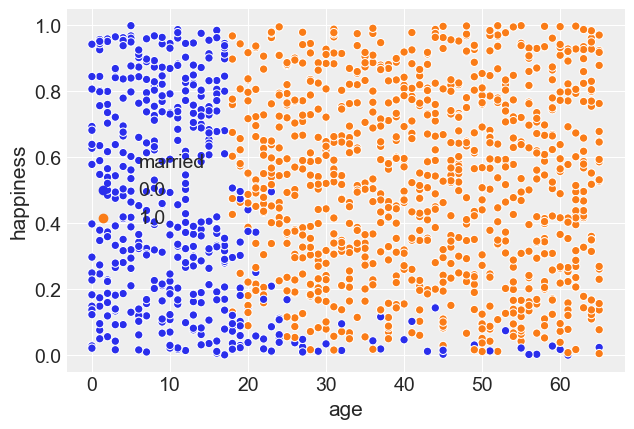

In [227]:
sns.scatterplot(data.age,data.happiness,hue=data.married);

In [228]:
data.describe()

,id,age,happiness,married
count,1320.000000,1320.000000,1320.000000,1320.000000
mean,1329.500000,32.500000,0.501680,0.672727
std,5.768467,19.057592,0.290748,0.469396
min,1320.000000,0.000000,0.000843,0.000000
25%,1324.750000,16.000000,0.246670,0.000000
50%,1329.500000,32.500000,0.504998,1.000000
75%,1334.250000,49.000000,0.760600,1.000000
max,1339.000000,65.000000,0.999460,1.000000


In [258]:
above_18 = data[data.age>17]
above_18['age_norm'] = (above_18.age-18)/(65-18)

In [263]:
with pm.Model() as model_age:
    a = pm.Normal('alpha',0,1,shape=2)
    beta = pm.Normal('beta',0,2)
    mu_hap = pm.Deterministic('mu',a[above_18.married.astype(int)]+  beta*above_18.age_norm)
    sigma = pm.Exponential('sigma',1)
    happ = pm.Normal('happ',mu_hap,sigma,observed = above_18.happiness)
    trace_age = pm.sample(1000,tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:06<00:00, 1215.66draws/s]


In [260]:
varnames = '~mu'

In [264]:
az.summary(trace_age,var_names=varnames)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.114,0.037,0.038,0.179,0.001,0.0,3350.0,3199.0,3350.0,2506.0,1.0
alpha[1],0.552,0.019,0.517,0.586,0.000,0.0,2275.0,2264.0,2270.0,2301.0,1.0
beta,-0.049,0.031,-0.108,0.009,0.001,0.0,2273.0,2023.0,2267.0,2234.0,1.0
sigma,0.276,0.006,0.265,0.288,0.000,0.0,4128.0,4124.0,4124.0,2783.0,1.0


In [266]:
with pm.Model() as model_age_2:
    a = pm.Normal('alpha',0,1,shape=1)
    beta = pm.Normal('beta',0,2)
    mu_hap = pm.Deterministic('mu',a +  beta*above_18.age_norm)
    sigma = pm.Exponential('sigma',1)
    happ = pm.Normal('happ',mu_hap,sigma,observed = above_18.happiness)
    trace_age_2 = pm.sample(1000,tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:03<00:00, 2136.30draws/s]


In [267]:
az.summary(trace_age_2,var_names=varnames)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.482,0.019,0.447,0.518,0.000,0.000,2031.0,2031.0,2031.0,2043.0,1.0
beta,0.038,0.032,-0.023,0.099,0.001,0.001,1930.0,1804.0,1928.0,1849.0,1.0
sigma,0.294,0.007,0.281,0.306,0.000,0.000,2401.0,2396.0,2403.0,2183.0,1.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x14cccd810>],
      dtype=object)

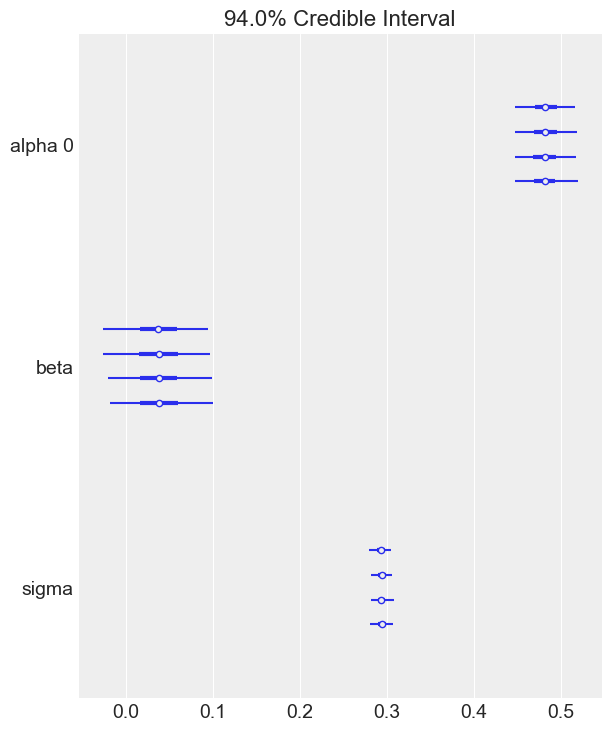

In [268]:
az.plot_forest(trace_age_2,var_names=varnames)

```
Age -> Marriage <- Happiness

If we condition on marriage to regress on happiness, this creates a statistical association or statistical confound.
Marriage is therefore a collider. Even though there is no causal association between happiness and age, if we condition on marriage  which means here, if we include it as a predictor in a regression then it will induce a statis- tical association between age and happiness. 
```

#### If you don’t have a causal model, you can’t make inferences from a multiple regression. And the regression itself does not provide the evidence you need to justify a causal model. Instead, you need some science.

### Haunted DAG

In [269]:
n = 100

In [270]:
b_gp = 1
b_gc = 0
b_pc = 1
b_u = 2

In [288]:
u = 2*sc.stats.bernoulli.rvs(0.5,size=n) -1

In [294]:
g = sc.stats.norm.rvs(size=n)

In [295]:
p = sc.stats.norm.rvs(loc=b_u*u + b_gp*g,size=n)

In [296]:
c = sc.stats.norm.rvs(loc=b_u*u + b_gc*g + b_pc*p,size=n)

In [297]:
data = pd.DataFrame({'u':u,'g':g,'p':p,'c':c})

In [298]:
data.head()

,u,g,p,c
0,1,-1.092129,-0.000373,3.525520
1,1,-1.128552,-0.690007,0.256744
2,1,1.675151,3.348579,5.040590
3,-1,-0.229107,-1.550614,-3.126363
4,-1,-0.153391,-0.157488,-0.249086


In [299]:
with pm.Model() as model_grandparent:
    alpha = pm.Normal('alpha',mu=0,sigma=1)
    B_PC = pm.Normal('B_PC',mu=0,sigma=1)
    B_GC = pm.Normal('B_GC',mu=0,sigma=1)
    sigma = pm.Exponential('sigma',1)
    mu = pm.Deterministic('mu',alpha + B_PC*data.p + B_GC*data.g)
    c = pm.Normal('child',mu=mu,sigma=sigma,observed = data.c)
    trace_grandparent = pm.sample(1000,tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, B_GC, B_PC, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 2687.67draws/s]


In [301]:
az.summary(trace_grandparent,var_names=varnames)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-0.012,0.152,-0.293,0.272,0.002,0.002,5350.0,2066.0,5330.0,2965.0,1.0
B_PC,1.826,0.070,1.692,1.952,0.001,0.001,3421.0,3421.0,3419.0,3035.0,1.0
B_GC,-1.020,0.177,-1.353,-0.691,0.003,0.002,3369.0,3369.0,3382.0,3058.0,1.0
sigma,1.496,0.109,1.286,1.689,0.002,0.001,3940.0,3761.0,4111.0,2893.0,1.0


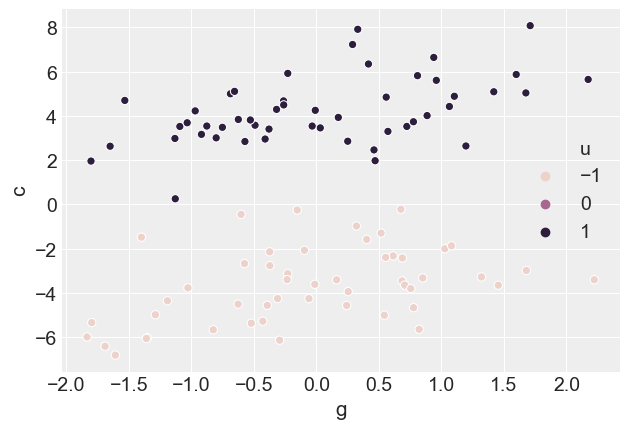

In [302]:
sns.scatterplot(data.g,data.c,hue=data.u)

In [303]:
with pm.Model() as model_grandparent_2:
    alpha = pm.Normal('alpha',mu=0,sigma=1)
    B_PC = pm.Normal('B_PC',mu=0,sigma=1)
    B_GC = pm.Normal('B_GC',mu=0,sigma=1)
    B_U = pm.Normal('B_U',mu=0,sigma=1)
    sigma = pm.Exponential('sigma',1)
    mu = pm.Deterministic('mu',alpha + B_PC*data.p + B_GC*data.g + B_U*data.u)
    c = pm.Normal('child',mu=mu,sigma=sigma,observed = data.c)
    trace_grandparent_2 = pm.sample(1000,tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, B_U, B_GC, B_PC, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:04<00:00, 1801.62draws/s]


In [304]:
az.summary(trace_grandparent_2,var_names=varnames)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.129,0.105,-0.075,0.317,0.002,0.001,3455.0,2727.0,3489.0,2686.0,1.0
B_PC,0.976,0.102,0.785,1.168,0.002,0.002,1804.0,1804.0,1804.0,2000.0,1.0
B_GC,-0.205,0.150,-0.483,0.077,0.003,0.002,2180.0,2090.0,2173.0,2521.0,1.0
B_U,2.075,0.214,1.673,2.468,0.005,0.004,1859.0,1828.0,1855.0,2069.0,1.0
sigma,1.050,0.077,0.907,1.194,0.001,0.001,3310.0,3264.0,3356.0,2041.0,1.0


## Confonting Confounding

>effective inference is possible, if we are careful enough and knowledgable enough.

```
Region --------
   |           |
   v           v
Education -> Wage

We need to find causal effect of Education on wage, but this unkown variable region will create a confound as there are 2 paths:
    1. Education -> Wage
    2. Region -> Education -> Wage
To solve this problem condition on region to remove the confound created by 2nd path and then regress on Education and wage, this will give pure causal effect.

```


#### Blocking the Backdoor

>**Blocking all confounding paths between some predictor X and some outcome Y is known as shutting the backdoor**

```
Some good news. Given a causal DAG, it is always possible to say which, if any, variables one must control for in order to shut all the backdoor paths. It is also possible to say which variables one must not control for, in order to leave the path of interest open
There are only four types of variable relations that com- bine to form all possible paths. 
```

```
write about:
    1. 4 kind of relations
    2. recipes to block the backdoor
    3. few examples and text
    4. using libs (dowhy / causalinfernce )
 ```